# Hierarchical Temporal Encoder - v3 Scenarios (Google Colab)

Train the **Hierarchical Temporal Encoder** on `scenarios_v3` graphs and generate embeddings for all ~5000 scenarios.

## Architecture

```
ENCODER (Bottom-Up)
  Assets (variable)  -> Sparse GAT  -> Pooling
  Zones              -> Sparse GAT  -> Pooling
  Regions            -> Sparse GAT  -> Pooling
  Nation (1 node)    -> Temporal Transformer (Dense)

DECODER (Top-Down)
  Nation -> Regions -> Zones -> Assets
  (with skip connections at each level)
```

## Requirements

- **GPU**: A100 (40GB / 80GB recommended)
- **Google Drive**: `benchmark/` folder at `/content/drive/MyDrive/benchmark`

## 1. Mount Google Drive

In [ ]:
from google.colab import drive
import os
from pathlib import Path

drive.mount('/content/drive', force_remount=True)

REPO_PATH = Path('/content/drive/MyDrive/benchmark')
os.chdir(REPO_PATH)

print(f'Repository path: {REPO_PATH}')
print(f'Current directory: {os.getcwd()}')
print(f'  src/ exists: {(REPO_PATH / "src").exists()}')
print(f'  outputs/graphs/hetero_temporal_v3/ exists: {(REPO_PATH / "outputs/graphs/hetero_temporal_v3").exists()}')
print(f'  outputs/scenarios_v3/ exists: {(REPO_PATH / "outputs/scenarios_v3").exists()}')

if not (REPO_PATH / 'src').exists():
    raise RuntimeError(
        f'Repository not found at {REPO_PATH}\n'
        'Please ensure your benchmark folder is in Google Drive at:\n'
        '/content/drive/MyDrive/benchmark'
    )

Mounted at /content/drive
Repository path: /content/drive/MyDrive/benchmark
Current directory: /content/drive/MyDrive/benchmark
  src/ exists: True
  outputs/graphs/hetero_temporal_v3/ exists: True
  outputs/scenarios_v3/ exists: True


## 2. Verify GPU

In [ ]:
import torch

print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
print(f'CUDA version: {torch.version.cuda}')

if torch.cuda.is_available():
    print(f'GPU Device: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9} GB')
    print(f'Number of GPUs: {torch.cuda.device_count()}')
else:
    print('WARNING: No GPU detected! Enable GPU in Runtime > Change runtime type')

PyTorch version: 2.5.1+cu124
CUDA available: True
CUDA version: 12.4
GPU Device: NVIDIA H100 80GB HBM3
GPU Memory: 85.169143808 GB
Number of GPUs: 1


## 3. Install Dependencies

In [ ]:
print('Installing PyTorch 2.5.1 and PyTorch Geometric...')

!pip uninstall -y torch torchvision torchaudio torch-scatter torch-sparse torch-geometric

!pip install -q torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

!pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install -q torch-geometric

!pip install -q numpy scipy tqdm matplotlib seaborn pandas

print('\nAll dependencies installed!')

Installing PyTorch 2.5.1 and PyTorch Geometric...
Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 154.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 136.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 116.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 145.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 M

## 4. Verify Dataset

In [ ]:
import json
import numpy as np
import torch
from pathlib import Path

data_dir = REPO_PATH / 'outputs/graphs/hetero_temporal_v3'
index_path = data_dir / 'dataset_index.json'

if not index_path.exists():
    raise FileNotFoundError(f'Dataset index not found at {index_path}')

with open(index_path, 'r') as f:
    index_data = json.load(f)

entries = index_data['entries']
print(f'Total graphs: {len(entries)}')

# Show N_base distribution
n_bases = [e['N_base'] for e in entries]
print(f'N_base range: [{min(n_bases)}, {max(n_bases)}]  mean={np.mean(n_bases):.0f}')
print(f'T: {entries[0]["T"]}')

# Load first graph to inspect
first_rel = entries[0]['graph_file'].replace('\\', '/')
first_graph = REPO_PATH / first_rel
sample = np.load(first_graph, allow_pickle=True)

node_feature_dim = sample['node_features'].shape[1]
meta = sample['meta'].item()

print(f'\nSample graph:')
print(f'  Node features shape: {sample["node_features"].shape}')
print(f'  Edge index shape:    {sample["edge_index"].shape}')
print(f'  Node types shape:    {sample["node_types"].shape}')
print(f'  Feature dim:         {node_feature_dim}')
print(f'  N_base:              {meta["N_base"]}')
print(f'  T:                   {meta["T"]}')

# Node type distribution (base graph)
node_types_base = sample['node_types'][:meta['N_base']]
unique_types, counts = np.unique(node_types_base, return_counts=True)
type_names = {0: 'Nation', 1: 'Region', 2: 'Zone', 3: 'Asset', 4: 'Weather'}
print(f'\nNode Type Distribution (base graph):')
for nt, count in zip(unique_types, counts):
    print(f'  Type {nt} ({type_names.get(nt, "Unknown")}): {count} nodes')

Total graphs: 5000
N_base range: [33, 851]  mean=464
T: 24

Sample graph:
  Node features shape: (19992, 14)
  Edge index shape:    (2, 22144)
  Node types shape:    (19992,)
  Feature dim:         14
  N_base:              833
  T:                   24

Node Type Distribution (base graph):
  Type 0 (Nation): 1 nodes
  Type 1 (Region): 16 nodes
  Type 2 (Zone): 123 nodes
  Type 3 (Asset): 677 nodes
  Type 4 (Weather): 16 nodes


## 5. Configuration

In [ ]:
import sys
sys.path.insert(0, str(REPO_PATH))

from src.gnn.embeddings.config import TrainingConfig

config = TrainingConfig()

print('Training Configuration:')
print(f'  Data dir:         {config.data_dir}')
print(f'  Save dir:         {config.save_dir}')
print(f'  Hidden dim:       {config.hidden_dim}')
print(f'  Spatial layers:   {config.num_spatial_layers}')
print(f'  Temporal layers:  {config.num_temporal_layers}')
print(f'  Attention heads:  {config.num_heads}')
print(f'  Epochs:           {config.epochs}')
print(f'  Batch size:       {config.batch_size}')
print(f'  Accum. steps:     {config.accumulation_steps}')
print(f'  Effective batch:  {config.effective_batch_size}')
print(f'  Learning rate:    {config.lr}')
print(f'  Device:           {config.device}')

Training Configuration:
  Data dir:         /content/drive/MyDrive/benchmark/outputs/graphs/hetero_temporal_v3
  Save dir:         /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal_v3
  Hidden dim:       128
  Spatial layers:   2
  Temporal layers:  4
  Attention heads:  8
  Epochs:           150
  Batch size:       1
  Accum. steps:     8
  Effective batch:  8
  Learning rate:    0.00015
  Device:           cuda


## 6. Load Dataset & Compute Normalization Stats

In [ ]:
from src.gnn.embeddings.dataset import load_dataset_v3, compute_norm_stats

print('Loading dataset...')
dataset, train_loader, val_loader, split_info = load_dataset_v3(config)

print(f'Total graphs:   {len(dataset)}')
print(f'Train batches:  {len(train_loader)}')
print(f'Val batches:    {len(val_loader)}')
print(f'Split saved to: {config.data_dir}')

print('\nComputing normalization statistics on training set...')
train_mean, train_std = compute_norm_stats(
    train_loader.dataset, device=config.device,
)
print(f'Mean (first 4 dims): {train_mean[:4]}')
print(f'Std  (first 4 dims): {train_std[:4]}')

Loading dataset...
Total graphs:   5000
Train batches:  4000
Val batches:    1000
Split saved to: /content/drive/MyDrive/benchmark/outputs/graphs/hetero_temporal_v3

Computing normalization statistics on training set...
Mean (first 4 dims): tensor([176.8015,  80.9445, 103.4833,  50.0411], device='cuda:0')
Std  (first 4 dims): tensor([483.3662, 533.6653, 790.2863, 369.3106], device='cuda:0')


## 7. Create Model

In [ ]:
import gc
from src.gnn.models.hierarchical_temporal_encoder import HierarchicalTemporalEncoder

print('Creating Hierarchical Temporal Encoder...')
model = HierarchicalTemporalEncoder(
    node_feature_dim=node_feature_dim,
    hidden_dim=config.hidden_dim,
    num_spatial_layers=config.num_spatial_layers,
    num_temporal_layers=config.num_temporal_layers,
    num_heads=config.num_heads,
    dropout=config.dropout,
)
model = model.to(config.device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total parameters:     {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f'Model size:           ~{total_params * 4 / 1e6:.2f} MB (FP32)')

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    print(f'\nGPU Memory:')
    print(f'  Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB')
    print(f'  Reserved:  {torch.cuda.memory_reserved(0) / 1e9:.2f} GB')
    total_mem = torch.cuda.get_device_properties(0).total_memory
    print(f'  Free:      {(total_mem - torch.cuda.memory_reserved(0)) / 1e9:.2f} GB')

Creating Hierarchical Temporal Encoder...
Total parameters:     3,185,664
Trainable parameters: 3,185,664
Model size:           ~12.74 MB (FP32)

GPU Memory:
  Allocated: 0.01 GB
  Reserved:  0.01 GB
  Free:      85.15 GB


## 8. Sanity Check (single batch)

In [ ]:
from src.gnn.embeddings.dataset import get_hierarchy_from_batch

batch0 = next(iter(train_loader)).to(config.device)
h = get_hierarchy_from_batch(batch0, config.device)

print(f'hierarchy keys:   {list(h.keys())}')
print(f'asset_to_zone:    {h["asset_to_zone"].shape} {h["asset_to_zone"].dtype}')
print(f'zone_to_region:   {h["zone_to_region"].shape} {h["zone_to_region"].dtype}')
print(f'batch.x:          {batch0.x.shape}')
print(f'batch.N_base:     {batch0.N_base}')
print(f'batch.T:          {batch0.T}')

hierarchy keys:   ['asset_to_zone', 'zone_to_region']
asset_to_zone:    torch.Size([203]) torch.int64
zone_to_region:   torch.Size([32]) torch.int64
batch.x:          torch.Size([4872, 14])
batch.N_base:     tensor([203], device='cuda:0')
batch.T:          tensor([24], device='cuda:0')


## 9. Train Model

In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

torch.cuda.empty_cache()
gc.collect()

from src.gnn.embeddings.train import run_training

history = run_training(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    train_mean=train_mean,
    train_std=train_std,
)


Starting training for 150 epochs ...
  Early Stopping Patience : 10
  Gradient Accumulation   : 8
  Effective Batch Size    : 8


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch   1/150 | Train: 5.2874 | Val: 4.1998 | LR: 0.000030 | Time: 607.4s
  -> Saved BEST model (val_loss=4.1998)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch   2/150 | Train: 4.4071 | Val: 3.9805 | LR: 0.000045 | Time: 339.5s
  -> Saved BEST model (val_loss=3.9805)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch   3/150 | Train: 4.1663 | Val: 3.8913 | LR: 0.000060 | Time: 341.6s
  -> Saved BEST model (val_loss=3.8913)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch   4/150 | Train: 3.9659 | Val: 3.7182 | LR: 0.000075 | Time: 344.4s
  -> Saved BEST model (val_loss=3.7182)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch   5/150 | Train: 3.7799 | Val: 3.6074 | LR: 0.000090 | Time: 351.3s
  -> Saved BEST model (val_loss=3.6074)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch   6/150 | Train: 3.6504 | Val: 3.5119 | LR: 0.000105 | Time: 352.4s
  -> Saved BEST model (val_loss=3.5119)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch   7/150 | Train: 3.4639 | Val: 3.4690 | LR: 0.000120 | Time: 352.9s
  -> Saved BEST model (val_loss=3.4690)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch   8/150 | Train: 3.3313 | Val: 3.4270 | LR: 0.000135 | Time: 350.2s
  -> Saved BEST model (val_loss=3.4270)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch   9/150 | Train: 3.2547 | Val: 3.4065 | LR: 0.000150 | Time: 336.2s
  -> Saved BEST model (val_loss=3.4065)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  10/150 | Train: 3.1519 | Val: 3.3694 | LR: 0.000150 | Time: 336.0s
  -> Saved BEST model (val_loss=3.3694)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  11/150 | Train: 3.0741 | Val: 3.3459 | LR: 0.000150 | Time: 332.3s
  -> Saved BEST model (val_loss=3.3459)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  12/150 | Train: 3.0204 | Val: 3.3337 | LR: 0.000150 | Time: 336.9s
  -> Saved BEST model (val_loss=3.3337)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  13/150 | Train: 2.9804 | Val: 3.3044 | LR: 0.000150 | Time: 338.3s
  -> Saved BEST model (val_loss=3.3044)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  14/150 | Train: 2.9504 | Val: 3.2938 | LR: 0.000150 | Time: 337.5s
  -> Saved BEST model (val_loss=3.2938)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  15/150 | Train: 2.9236 | Val: 3.2865 | LR: 0.000150 | Time: 342.2s
  -> Saved BEST model (val_loss=3.2865)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  16/150 | Train: 2.9034 | Val: 3.2765 | LR: 0.000149 | Time: 339.5s
  -> Saved BEST model (val_loss=3.2765)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  17/150 | Train: 2.8831 | Val: 3.2695 | LR: 0.000149 | Time: 341.3s
  -> Saved BEST model (val_loss=3.2695)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  18/150 | Train: 2.8617 | Val: 3.2574 | LR: 0.000149 | Time: 338.9s
  -> Saved BEST model (val_loss=3.2574)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  19/150 | Train: 2.8435 | Val: 3.2372 | LR: 0.000148 | Time: 341.2s
  -> Saved BEST model (val_loss=3.2372)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  20/150 | Train: 2.8257 | Val: 3.2472 | LR: 0.000148 | Time: 342.0s
  -> No improvement (1/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  21/150 | Train: 2.8107 | Val: 3.2490 | LR: 0.000148 | Time: 342.9s
  -> No improvement (2/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  22/150 | Train: 2.7967 | Val: 3.2258 | LR: 0.000147 | Time: 341.3s
  -> Saved BEST model (val_loss=3.2258)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  23/150 | Train: 2.7853 | Val: 3.2172 | LR: 0.000147 | Time: 342.6s
  -> Saved BEST model (val_loss=3.2172)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  24/150 | Train: 2.7756 | Val: 3.2142 | LR: 0.000146 | Time: 339.2s
  -> Saved BEST model (val_loss=3.2142)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  25/150 | Train: 2.7669 | Val: 3.2150 | LR: 0.000146 | Time: 342.8s
  -> No improvement (1/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  26/150 | Train: 2.7600 | Val: 3.2153 | LR: 0.000145 | Time: 342.9s
  -> No improvement (2/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  27/150 | Train: 2.7529 | Val: 3.2084 | LR: 0.000145 | Time: 342.2s
  -> Saved BEST model (val_loss=3.2084)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  28/150 | Train: 2.7456 | Val: 3.2003 | LR: 0.000144 | Time: 341.9s
  -> Saved BEST model (val_loss=3.2003)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  29/150 | Train: 2.7363 | Val: 3.1989 | LR: 0.000143 | Time: 344.3s
  -> Saved BEST model (val_loss=3.1989)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  30/150 | Train: 2.7345 | Val: 3.1952 | LR: 0.000143 | Time: 343.8s
  -> Saved BEST model (val_loss=3.1952)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  31/150 | Train: 2.7276 | Val: 3.1925 | LR: 0.000142 | Time: 340.9s
  -> Saved BEST model (val_loss=3.1925)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  32/150 | Train: 2.7226 | Val: 3.1899 | LR: 0.000141 | Time: 342.3s
  -> Saved BEST model (val_loss=3.1899)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  33/150 | Train: 2.7169 | Val: 3.1954 | LR: 0.000140 | Time: 341.5s
  -> No improvement (1/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  34/150 | Train: 2.7123 | Val: 3.1827 | LR: 0.000139 | Time: 341.1s
  -> Saved BEST model (val_loss=3.1827)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  35/150 | Train: 2.7074 | Val: 3.1754 | LR: 0.000139 | Time: 340.8s
  -> Saved BEST model (val_loss=3.1754)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  36/150 | Train: 2.7031 | Val: 3.1736 | LR: 0.000138 | Time: 342.5s
  -> Saved BEST model (val_loss=3.1736)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  37/150 | Train: 2.6984 | Val: 3.1678 | LR: 0.000137 | Time: 337.7s
  -> Saved BEST model (val_loss=3.1678)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  38/150 | Train: 2.6932 | Val: 3.1774 | LR: 0.000136 | Time: 340.0s
  -> No improvement (1/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  39/150 | Train: 2.6887 | Val: 3.1664 | LR: 0.000135 | Time: 339.3s
  -> Saved BEST model (val_loss=3.1664)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  40/150 | Train: 2.6858 | Val: 3.1646 | LR: 0.000134 | Time: 340.9s
  -> Saved BEST model (val_loss=3.1646)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  41/150 | Train: 2.6819 | Val: 3.1554 | LR: 0.000133 | Time: 341.4s
  -> Saved BEST model (val_loss=3.1554)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  42/150 | Train: 2.6788 | Val: 3.1607 | LR: 0.000131 | Time: 340.0s
  -> No improvement (1/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  43/150 | Train: 2.6757 | Val: 3.1509 | LR: 0.000130 | Time: 340.8s
  -> Saved BEST model (val_loss=3.1509)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  44/150 | Train: 2.6723 | Val: 3.1539 | LR: 0.000129 | Time: 337.6s
  -> No improvement (1/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  45/150 | Train: 2.6702 | Val: 3.1389 | LR: 0.000128 | Time: 339.8s
  -> Saved BEST model (val_loss=3.1389)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  46/150 | Train: 2.6688 | Val: 3.1393 | LR: 0.000127 | Time: 341.8s
  -> No improvement (1/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  47/150 | Train: 2.6655 | Val: 3.1383 | LR: 0.000126 | Time: 339.6s
  -> Saved BEST model (val_loss=3.1383)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  48/150 | Train: 2.6627 | Val: 3.1449 | LR: 0.000124 | Time: 339.1s
  -> No improvement (1/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  49/150 | Train: 2.6598 | Val: 3.1382 | LR: 0.000123 | Time: 338.8s
  -> Saved BEST model (val_loss=3.1382)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  50/150 | Train: 2.6586 | Val: 3.1409 | LR: 0.000122 | Time: 337.1s
  -> No improvement (1/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  51/150 | Train: 2.6562 | Val: 3.1400 | LR: 0.000120 | Time: 337.7s
  -> No improvement (2/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  52/150 | Train: 2.6543 | Val: 3.1299 | LR: 0.000119 | Time: 337.9s
  -> Saved BEST model (val_loss=3.1299)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  53/150 | Train: 2.6520 | Val: 3.1345 | LR: 0.000118 | Time: 338.1s
  -> No improvement (1/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  54/150 | Train: 2.6491 | Val: 3.1309 | LR: 0.000116 | Time: 334.9s
  -> No improvement (2/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  55/150 | Train: 2.6471 | Val: 3.1314 | LR: 0.000115 | Time: 335.1s
  -> No improvement (3/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  56/150 | Train: 2.6465 | Val: 3.1312 | LR: 0.000113 | Time: 334.2s
  -> No improvement (4/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  57/150 | Train: 2.6431 | Val: 3.1273 | LR: 0.000112 | Time: 333.3s
  -> Saved BEST model (val_loss=3.1273)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  58/150 | Train: 2.6414 | Val: 3.1256 | LR: 0.000111 | Time: 335.4s
  -> Saved BEST model (val_loss=3.1256)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  59/150 | Train: 2.6397 | Val: 3.1223 | LR: 0.000109 | Time: 335.1s
  -> Saved BEST model (val_loss=3.1223)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  60/150 | Train: 2.6364 | Val: 3.1302 | LR: 0.000108 | Time: 326.0s
  -> No improvement (1/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  61/150 | Train: 2.6360 | Val: 3.1213 | LR: 0.000106 | Time: 327.4s
  -> Saved BEST model (val_loss=3.1213)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  62/150 | Train: 2.6338 | Val: 3.1229 | LR: 0.000104 | Time: 322.7s
  -> No improvement (1/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  63/150 | Train: 2.6320 | Val: 3.1187 | LR: 0.000103 | Time: 320.7s
  -> Saved BEST model (val_loss=3.1187)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  64/150 | Train: 2.6307 | Val: 3.1188 | LR: 0.000101 | Time: 318.7s
  -> No improvement (1/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  65/150 | Train: 2.6289 | Val: 3.1229 | LR: 0.000100 | Time: 320.8s
  -> No improvement (2/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  66/150 | Train: 2.6265 | Val: 3.1241 | LR: 0.000098 | Time: 321.8s
  -> No improvement (3/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  67/150 | Train: 2.6247 | Val: 3.1207 | LR: 0.000097 | Time: 321.5s
  -> No improvement (4/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  68/150 | Train: 2.6225 | Val: 3.1184 | LR: 0.000095 | Time: 320.9s
  -> Saved BEST model (val_loss=3.1184)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  69/150 | Train: 2.6206 | Val: 3.1230 | LR: 0.000093 | Time: 320.6s
  -> No improvement (1/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  70/150 | Train: 2.6200 | Val: 3.1153 | LR: 0.000092 | Time: 318.7s
  -> Saved BEST model (val_loss=3.1153)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  71/150 | Train: 2.6190 | Val: 3.1099 | LR: 0.000090 | Time: 318.5s
  -> Saved BEST model (val_loss=3.1099)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  72/150 | Train: 2.6187 | Val: 3.1168 | LR: 0.000088 | Time: 321.3s
  -> No improvement (1/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  73/150 | Train: 2.6165 | Val: 3.1104 | LR: 0.000087 | Time: 328.1s
  -> No improvement (2/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  74/150 | Train: 2.6159 | Val: 3.1177 | LR: 0.000085 | Time: 326.4s
  -> No improvement (3/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  75/150 | Train: 2.6149 | Val: 3.1186 | LR: 0.000083 | Time: 329.0s
  -> No improvement (4/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  76/150 | Train: 2.6126 | Val: 3.1158 | LR: 0.000082 | Time: 330.4s
  -> No improvement (5/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  77/150 | Train: 2.6123 | Val: 3.1162 | LR: 0.000080 | Time: 326.0s
  -> No improvement (6/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  78/150 | Train: 2.6105 | Val: 3.1173 | LR: 0.000078 | Time: 326.8s
  -> No improvement (7/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  79/150 | Train: 2.6096 | Val: 3.1133 | LR: 0.000077 | Time: 326.4s
  -> No improvement (8/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  80/150 | Train: 2.6086 | Val: 3.1128 | LR: 0.000075 | Time: 324.0s
  -> No improvement (9/10)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch  81/150 | Train: 2.6085 | Val: 3.1100 | LR: 0.000073 | Time: 321.7s
  -> No improvement (10/10)

Early stopping triggered after 81 epochs.

Training complete!  Best val loss: 3.109946
Model saved to: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal_v3


## 10. Training Curves

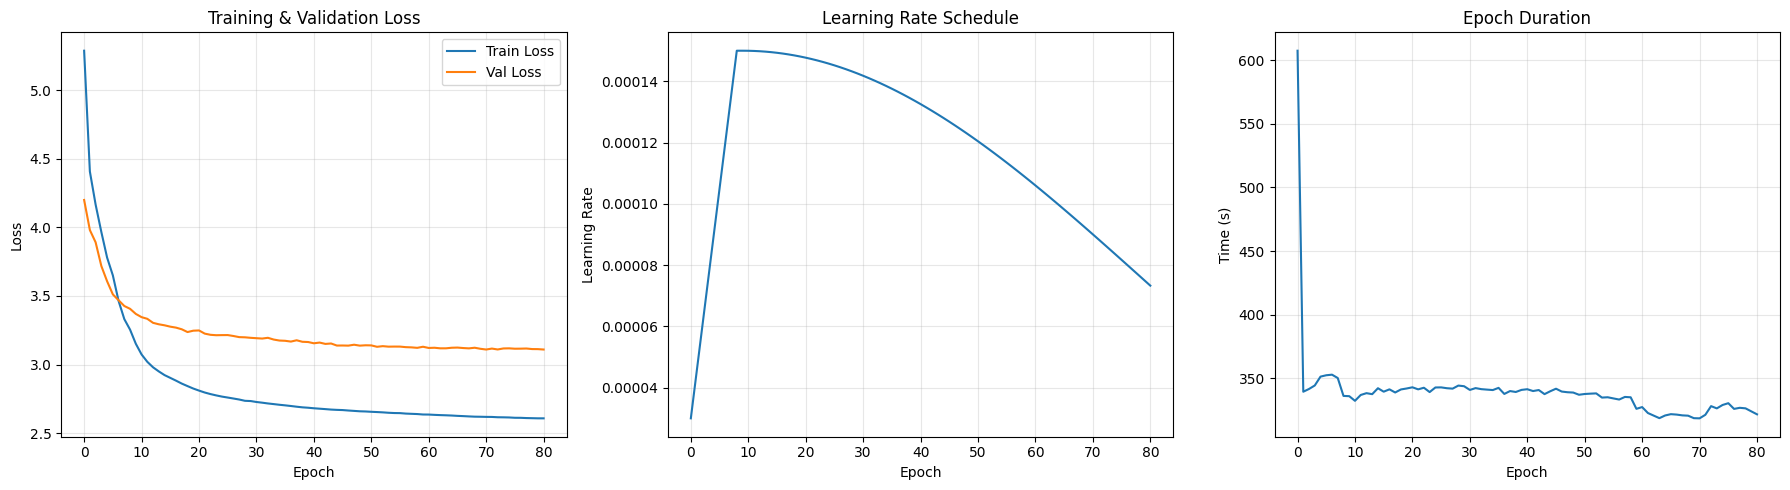

Best val loss: 3.109946
Total training time: 457.8 min


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate
axes[1].plot(history['lr'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].grid(True, alpha=0.3)

# Epoch time
axes[2].plot(history['epoch_time'])
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Time (s)')
axes[2].set_title('Epoch Duration')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(Path(config.save_dir) / 'training_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f'Best val loss: {min(history["val_loss"]):.6f}')
print(f'Total training time: {sum(history["epoch_time"]) / 60:.1f} min')

## 11. Load Best Model & Generate Embeddings

In [ ]:
from src.gnn.embeddings.generate import generate_embeddings

# Load best checkpoint
save_dir = Path(config.save_dir)
ckpt = torch.load(save_dir / 'best_encoder.pt', map_location=config.device, weights_only=False)
model.load_state_dict(ckpt['model_state_dict'])
print(f'Loaded best model from epoch {ckpt["epoch"]} (val_loss={ckpt["val_loss"]:.4f})')

# Use saved normalization stats
train_mean_loaded = ckpt['train_mean'].to(config.device)
train_std_loaded = ckpt['train_std'].to(config.device)

torch.cuda.empty_cache()
gc.collect()

manifest = generate_embeddings(
    model=model,
    config=config,
    train_mean=train_mean_loaded,
    train_std=train_std_loaded,
)
print(f'\nGenerated embeddings for {len(manifest)} scenarios')

Loaded best model from epoch 71 (val_loss=3.1099)
Generating embeddings for 5000 scenarios ...


Generating embeddings:   0%|          | 0/5000 [00:00<?, ?it/s]

Saved 5000 embeddings to /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal_v3/embeddings_v3
Manifest: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal_v3/embeddings_v3/manifest.json

Generated embeddings for 5000 scenarios


## 12. Inspect Embeddings

In [ ]:
import numpy as np

emb_dir = Path(config.save_dir) / 'embeddings_v3'
emb_files = sorted(emb_dir.glob('*.npz'))

print(f'Total embedding files: {len(emb_files)}')

# Inspect first few
for f in emb_files[:3]:
    data = np.load(f, allow_pickle=True)
    print(f'\n{f.name}:')
    print(f'  assets:  {data["assets"].shape}')
    print(f'  zones:   {data["zones"].shape}')
    print(f'  regions: {data["regions"].shape}')
    print(f'  nation:  {data["nation"].shape}')
    print(f'  N_base:  {data["N_base"]}')
    print(f'  T:       {data["T"]}')

Total embedding files: 5000

outputs\scenarios_v3\scenario_00001.npz:
  assets:  (833, 24, 128)
  zones:   (123, 24, 128)
  regions: (17, 24, 128)
  nation:  (24, 128)
  N_base:  833
  T:       24

outputs\scenarios_v3\scenario_00002.npz:
  assets:  (478, 24, 128)
  zones:   (76, 24, 128)
  regions: (8, 24, 128)
  nation:  (24, 128)
  N_base:  478
  T:       24

outputs\scenarios_v3\scenario_00003.npz:
  assets:  (785, 24, 128)
  zones:   (126, 24, 128)
  regions: (12, 24, 128)
  nation:  (24, 128)
  N_base:  785
  T:       24


## 13. Embedding Visualization (t-SNE)

Embedding matrix: (500, 128)


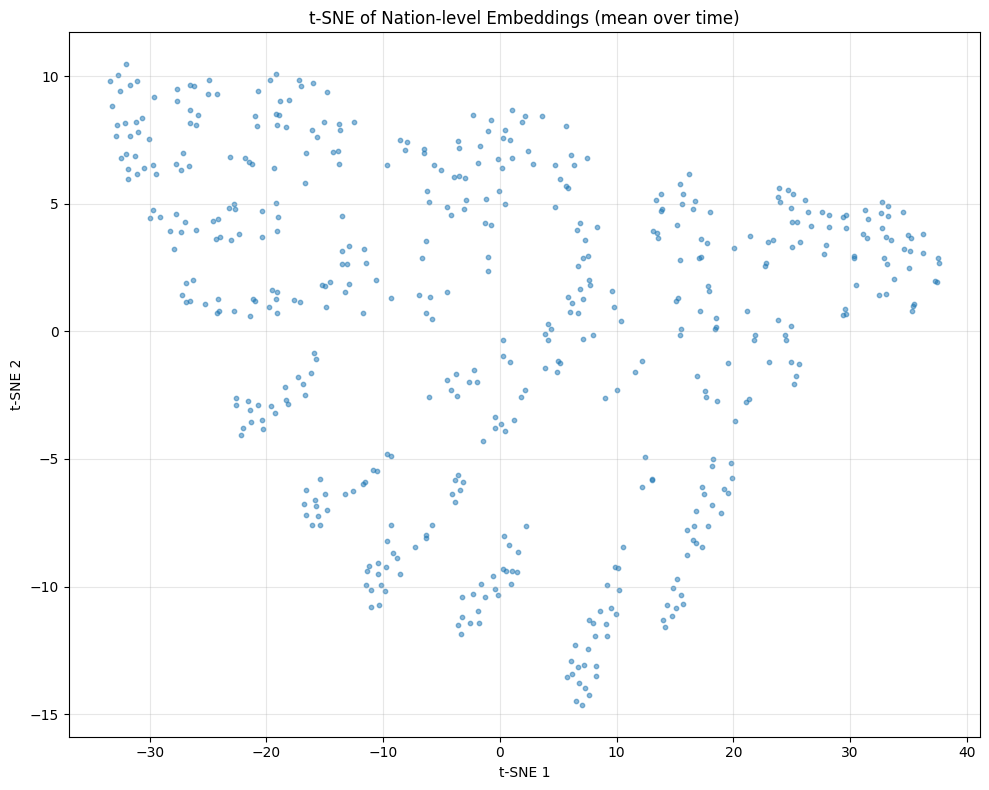

Done!


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Collect nation-level embeddings (mean over time) for a sample of scenarios
nation_embeddings = []
labels = []

sample_files = emb_files[:500]  # Use first 500 for visualization
for f in sample_files:
    data = np.load(f, allow_pickle=True)
    nation_emb = data['nation'].mean(axis=0)  # [D] mean over time
    nation_embeddings.append(nation_emb)
    labels.append(f.stem)

X = np.stack(nation_embeddings)
print(f'Embedding matrix: {X.shape}')

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.5, s=10)
plt.title('t-SNE of Nation-level Embeddings (mean over time)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(str(save_dir / 'tsne_nation_embeddings.png'), dpi=150, bbox_inches='tight')
plt.show()

print('Done!')